# Variational quantum simulation

The matrix equation becomes

$$
\begin{pmatrix}
    1 & 0\\
    0 & \frac{\alpha^{2}}{4}
\end{pmatrix}
\begin{pmatrix}
    \dot{\alpha}\\
    \dot{\theta}
\end{pmatrix}
= 
\begin{pmatrix}
    \frac{\alpha}{2}  <\tilde{\Psi}(\theta)| \sigma_{y} |\tilde{\Psi}(\theta)>\\
    \frac{\alpha^{2}}{2}(1-\frac{1}{2}<\tilde{\Psi}(\theta)| \sigma_{z} |\tilde{\Psi}(\theta)>)
\end{pmatrix}
$$

$$
\begin{pmatrix}
    \dot{\alpha}\\
    \dot{\theta}
\end{pmatrix}
= 
\text{Inverse}(\begin{pmatrix}
    1 & 0\\
    0 & \frac{\alpha^{2}}{4}
\end{pmatrix})
\begin{pmatrix}
    \frac{\alpha}{2} <\tilde{\Psi}(\theta)| \sigma_{y} |\tilde{\Psi}(\theta)>\\
    \frac{\alpha^{2}}{2}(1-\frac{1}{2}<\tilde{\Psi}(\theta)| \sigma_{z} |\tilde{\Psi}(\theta)>)
\end{pmatrix}
$$

### Variables at a later time

Euler algorithm to determine the variables at a later time
$$
\begin{pmatrix}
    \alpha(t+dt)\\
    \theta(t+dt)
\end{pmatrix}
= \begin{pmatrix}
    \alpha(t)\\
    \theta(t)
\end{pmatrix}+
dt
\begin{pmatrix}
    \dot{\alpha}\\
    \dot{\theta}
\end{pmatrix}
$$

### Expectation values of Pauli operators

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.opflow import X, Y, Z, I
from qiskit.opflow import CircuitStateFn
from qiskit.opflow.state_fns import StateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.opflow.converters import CircuitSampler
from qiskit.providers.aer import QasmSimulator


sigma_X = np.matrix([[0, 1],
                     [1, 0]])
# U_1(theta) = exp(-i * theta/2 * sigma_x)
def U_1(theta):
     return expm(-1j*(theta/2)*sigma_X)
    
def Expectation_Values(theta_1):
    
    psi = QuantumCircuit(1) # Initially |psi> = |0>.
    
    psi.unitary(U_1(theta_1),0) # |psi_tilde> = exp(-i * theta/2 * sigma_x) |0>.
    
    psi = CircuitStateFn(psi)
    
    # Performing <psi | sigma_Y |psi>.
    measurable_expression = StateFn(Y, is_measurement = True).compose(psi)

    # Expectation value in the sigma_z basis aka computational basis.
    expectation = PauliExpectation().convert(measurable_expression)

    # Simulating.
    simulator = QasmSimulator()
    sampler = CircuitSampler(simulator).convert(expectation)
    V_0 = sampler.eval().real # Returning the <psi | sigma_y |psi>.
    
    
    
    psi = QuantumCircuit(1) # Initially |psi> = |0>.
    
    psi.unitary(U_1(theta_1),0) # |psi_tilde> = exp(-i * theta/2 * sigma_x) |0>.
    
    psi = CircuitStateFn(psi)
    

    # Performing <psi | sigma_Z |psi>.
    measurable_expression = StateFn(Z, is_measurement = True).compose(psi)

    # Expectation value in the sigma_z basis aka computational basis.
    expectation = PauliExpectation().convert(measurable_expression)

    # Simulating.
    simulator = QasmSimulator()
    sampler = CircuitSampler(simulator).convert(expectation)
    V_1 = sampler.eval().real # Returning the <psi | sigma_z |psi>.  
    
    return V_0, V_1 # <psi|sigma_y|psi>, <psi|sigma_z|psi>.

In [2]:
Expectation_Values(np.pi)

(0.01953125, -1.0)

In [3]:
t = 0.0
dt = 0.15
Time = [t]

alpha_0 = 1
theta_0 = 0.0

alpha = alpha_0
theta = theta_0

alpha_s = [alpha]
theta_s = [theta]

# Run the expectation value.
M = Expectation_Values(theta_0)
while t < 8:
    
    alpha_dot = (alpha/2) * M[0]
    theta_dot = 2-M[1]
    
    alpha = alpha + (dt * alpha_dot)
    theta = theta + (dt * theta_dot)
    
    alpha_s.append(alpha)
    theta_s.append(theta)
    t = t + dt
    Time.append(t)
    
    # Running with updated values of theta.
    M = Expectation_Values(theta) 

In [4]:
psi_initial = expm(-1j*theta_0*0.5*sigma_X)*np.matrix([[1],[0]]) # psi initial is set by choice of initial theta.
def L(alpha_list, theta_list):
    overlap_list = []
    psi_tilde_zero = expm(-1j*theta_0*0.5*sigma_X)*psi_initial
    for i in range(len(theta_list)):
        psi_tilde_t    = expm(-1j * theta_list[i] * 0.5*sigma_X)*psi_initial
        overlap_list.append((alpha_list[i]*abs(psi_tilde_t.getH()*psi_tilde_zero)).tolist()[0][0])
    return overlap_list

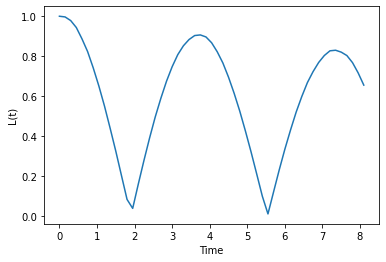

In [5]:
import matplotlib.pyplot as plt
plt.plot(Time,L(alpha_s,theta_s))
plt.xlabel("Time")
plt.ylabel("L(t)")
plt.show()

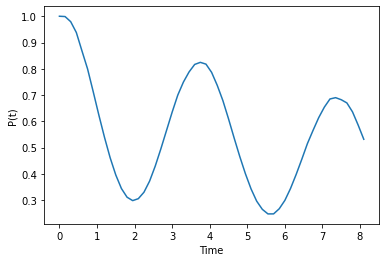

In [6]:
plt.plot(Time,np.square(alpha_s)) # \alpha^2 = P(t) = |<psi(t)|psi(t)>|^2.
plt.xlabel("Time")
plt.ylabel("P(t)")
plt.show()

### Previous code

In [7]:
sigma_X = np.matrix([[0, 1], [1, 0]])
sigma_Y = np.matrix([[0,-1j],[1j,0]])
sigma_Z = np.matrix([[0,1],[1,0]])
def Psi_ansatz(alpha,theta,state_initial):
    return alpha * np.exp(-(1j/2)*theta*sigma_X)*state_initial

def Psi_tilde(theta,state_initial):
    return np.exp(-(1j/2)*theta*Pauli_X)*state_initial

# Second code for expectation values of Pauli operators

In [207]:
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import numpy as np
from numpy.linalg import inv
from scipy.linalg import expm

simulator = Aer.get_backend('aer_simulator')

vec = np.zeros(2)
vec[0] = 1
vec[1] = 0
ket_zero = Statevector(vec, dims=(2,))
#print(ket_zero)

sigma_X = np.matrix([[0, 1],
                     [1, 0]])

sigma_Y = np.matrix([[0, -1j],
                     [1j, 0]])


sigma_Z = np.matrix([[1, 0],
                     [0, -1]])

# U(theta) = exp(-i * theta/2 * sigma_x)
def U(theta):
     return expm(-1j*(theta/2)*sigma_X)

def Exp_Pauli_Y(theta, initial_psi):
    
    # Expectation value of pauli_y.
    qc = QuantumCircuit(1)
    
    qc.set_statevector(initial_psi) # Setting the initial qubit as initial_psi.
    
    qc.save_state()
    qc.unitary(U(theta),0) # |psi_tilde(theta)> = exp(-i * theta/2 * sigma_x) |0>.
    
    qc.measure_all()
    
    simulator = Aer.get_backend('aer_simulator')
    qc = transpile(qc, simulator)
    
    backend = Aer.get_backend('aer_simulator')
    shots = 1024
    job = execute(qc, backend=backend, shots=shots)
    job_monitor(job)
    result = job.result()
    
    qc.save_statevector() # This is |psi_tilde(theta)>.

    statevector = result.get_statevector(qc)    
    
    
    
    # In order to save |psi_tilde(theta)> we will apply 
    # sigma_y on |psi_tilde(theta)> on a different circuit.
    qc_1 = QuantumCircuit(1)
    qc_1.set_statevector(initial_psi) # Setting the initial qubit as initial_psi.
    qc_1.save_state()
    qc_1.unitary(U(theta),0) # |psi_tilde(theta)> = exp(-i * theta/2 * sigma_x) |0>.    
    qc_1.y(0) # sigma_y |psi_tilde(theta)>.
    
    qc_1.measure_all()
    
    simulator = Aer.get_backend('aer_simulator')
    qc_1 = transpile(qc_1, simulator)
    
    backend = Aer.get_backend('aer_simulator')
    shots = 1024
    job = execute(qc_1, backend=backend, shots=shots)
    job_monitor(job)
    result = job.result()
    
    qc_1.save_statevector() # This is sigma_y|psi_tilde(theta)>.

    statevector_1 = result.get_statevector(qc_1)    
    
    return (np.matrix([[statevector[0]],[statevector[1]]]).getH()*
            np.matrix([[statevector_1[0]],[statevector_1[1]]]),
            np.matrix([[statevector[0]],[statevector[1]]])) # <psi_tilde(theta)|sigma_y|psi_tilde(theta)>, |psi_tilde(theta)>

In [208]:
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import numpy as np
from numpy.linalg import inv
from scipy.linalg import expm

simulator = Aer.get_backend('aer_simulator')

vec = np.zeros(2)
vec[0] = 1
vec[1] = 0
ket_zero = Statevector(vec, dims=(2,))
#print(ket_zero)

sigma_X = np.matrix([[0, 1],
                     [1, 0]])

sigma_Y = np.matrix([[0, -1j],
                     [1j, 0]])


sigma_Z = np.matrix([[1, 0],
                     [0, -1]])

# U(theta) = exp(-i * theta/2 * sigma_x)
def U(theta):
     return expm(-1j*(theta/2)*sigma_X)

def Exp_Pauli_Z(theta, initial_psi):
    
    # Expectation value of pauli_y.
    qc = QuantumCircuit(1)
    
    qc.set_statevector(initial_psi) # Setting the initial qubit as initial_psi.
    
    qc.save_state()
    qc.unitary(U(theta),0) # |psi_tilde(theta)> = exp(-i * theta/2 * sigma_x) |0>.
    
    qc.measure_all()
    
    simulator = Aer.get_backend('aer_simulator')
    qc = transpile(qc, simulator)
    
    backend = Aer.get_backend('aer_simulator')
    shots = 1024
    job = execute(qc, backend=backend, shots=shots)
    job_monitor(job)
    result = job.result()
    
    qc.save_statevector() # This is |psi_tilde(theta)>.

    statevector = result.get_statevector(qc)    
    
    
    
    # In order to save |psi_tilde(theta)> we will apply 
    # sigma_y on |psi_tilde(theta)> on a different circuit.
    qc_1 = QuantumCircuit(1)
    qc_1.set_statevector(initial_psi) # Setting the initial qubit as initial_psi.
    qc_1.save_state()
    qc_1.unitary(U(theta),0) # |psi_tilde(theta)> = exp(-i * theta/2 * sigma_x) |0>.    
    qc_1.z(0) # sigma_z |psi_tilde(theta)>.
    
    qc_1.measure_all()
    
    simulator = Aer.get_backend('aer_simulator')
    qc_1 = transpile(qc_1, simulator)
    
    backend = Aer.get_backend('aer_simulator')
    shots = 1024
    job = execute(qc_1, backend=backend, shots=shots)
    job_monitor(job)
    result = job.result()
    
    qc_1.save_statevector() # This is sigma_y|psi_tilde(theta)>.

    statevector_1 = result.get_statevector(qc_1)    
    
    return (np.matrix([[statevector[0]],[statevector[1]]]).getH()*
            np.matrix([[statevector_1[0]],[statevector_1[1]]]),
            np.matrix([[statevector[0]],[statevector[1]]])) # <psi_tilde(theta)|sigma_y|psi_tilde(theta)>, |psi_tilde(theta)>

In [212]:
f = open('QAAS_data'+'.txt', 'w')

alpha = 1
theta = np.pi
psi = ket_zero
t = 0
dt = 0.15
while t < 5:
    alpha_dot = (alpha/2) * Exp_Pauli_Y(theta,psi)[0]
    theta_dot = 2-Exp_Pauli_Z(theta,psi)[0]
    psi = Exp_Pauli_Y(theta,psi)[1] # new psi.
    
    alpha = (alpha + (dt * alpha_dot))[0,0]
    theta = (theta + (dt * theta_dot))[0,0] 
    f = open('QAAS_data'+'.txt', 'a')
    f.write(str(t)+ '\t' + str(alpha) + '\t' + str(theta) + '\t' + str(psi[0,0]) + '\t' + str(psi[1,0]) +'\n')
    t += dt
    #print(alpha)
    #print(theta)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [ ]:
import numpy as np
from qiskit.quantum_info import Statevector

vec = np.zeros(2)
vec[0] = 1
vec[1] = 0
ket_zero = Statevector(vec, dims=(2,))
print(ket_zero)
#print(psi.to_dict())

In [ ]:
qc = QuantumCircuit(2)
st0 = Statevector.from_instruction(qc) 
qc.h(0)
st1 = Statevector.from_instruction(qc)
qc.cnot(0, 1)
st2 = Statevector.from_instruction(qc)

print(st0)
print(st1)
print(st2)